<a href="https://colab.research.google.com/github/gonzalezcortes/cryptocurrencies_covid/blob/main/SHAP_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the code for our research that aims to predict the price of Bitcoin and Ethereum during the novel coronavirus (COVID-19) pandemic.

## Libreries

In [ ]:
%%capture
!pip install shap
import shap

In [ ]:
#Varias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from tabulate import tabulate
import warnings
import itertools
import random
from sklearn.preprocessing import MinMaxScaler

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Google collab pro
from google.colab import drive
drive.mount('/content/drive')
ruta = '/content/drive/My Drive/Crypto_2021/Code/sample_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
name_assets = ['XRP', 'LTC', 'ETH', 'DOGE', 'PPC', 'BTS', 'XLM', 'NXT', 'MAID',
               'NMC', 'BTC', 'USDT', 'ADA', 'BNB','USDC']
trm = str('-USD.csv')

path_of_assets = [x+trm for x in name_assets]

## Preprocessing

In [ ]:
class Indicators:
    def norma(self, data, mini, maxi):
        z = (data-mini)/(maxi-mini)
        return z

    def desnorma(self, data, mini, maxi):
        d = (data*(maxi-mini))-mini
        return d

    def simple_ma(self, data, period):
        return data.rolling(period).mean()

    def rsi(self, data, period):
        ## ver np.where para acelerar
        change = data.diff()
        gain = pd.Series(list(map(lambda x: x if x > 0 else 0, change)))
        loss = pd.Series(list(map(lambda x: abs(x) if x < 0 else 0, change)))
        rs = gain.rolling(period).mean() / loss.rolling(period).mean()
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def stochastic_oscillator(self, data_close, data_low, data_high, period):
        so = 100*((data_close-data_low.rolling(period).min())/
                (data_close-data_high.rolling(period).max()-data_close-data_low.rolling(period).min()))
        return so

    def williams(self, data_close, data_low, data_high,period):
        r = ((data_high.rolling(period).max()-data_close)/
            (data_close-data_high.rolling(period).max()-data_close-data_low.rolling(period).min())) * -100
        return r

    def macd(self, data_close, p, q, r):
        #12,26,9
        signal_line = data_close.ewm(span=p, adjust=False).mean()-data_close.ewm(span=q, adjust=False).mean()
        return signal_line.ewm(span=r, adjust=False).mean()

    def obv(self, data_close, data_volumen):
        data_close = np.array(data_close)
        obv = np.zeros(data_close.shape)
        obv[0] = data_volumen[0]
        for i in range(1,data_close.shape[0]):
            if data_close[i] - data_close[i-1] > 0:
                obv[i] = obv[i-1] + data_volumen[i]
            elif data_close[i] - data_close[i-1] < 0:
                obv[i] = obv[i - 1] - data_volumen[i]
            else:
                obv[i] = obv[i-1]
        return obv

    def add_ma(self, data_set, name_data_set):
        data_set['ma_5 '+str(name_data_set)]  = self.simple_ma(data_set['Close'],5)
        data_set['ma_10 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 10)
        data_set['ma_20 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 20)
        data_set['ma_50 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 50)
        data_set['ma_100 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 100)
        data_set['ma_200 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 200)
        return data_set

    def add_indicators(self, data_set, name_data_set):
        data_set['rsi '+str(name_data_set)] = self.rsi(data_set['Close'], 14)
        data_set['stoch '+str(name_data_set)] = self.stochastic_oscillator(data_set['Close'],data_set['Low'],data_set["High"],14)
        data_set['williams '+str(name_data_set)] = self.williams(data_set['Close'],data_set['Low'],data_set["High"],14)
        data_set['macd '+str(name_data_set)] = self.macd(data_set['Close'], 12, 26, 9)
        data_set['obv '+str(name_data_set)] = self.obv(data_set['Close'],data_set['Volume'])
        return data_set

    def add_lags_close(self, data_set, name_data_set):
        data_set['1-day_close '+str(name_data_set)] = data_set['Close'].shift(1)
        data_set['2-day_close '+str(name_data_set)] = data_set['Close'].shift(2)
        data_set['3-day_close '+str(name_data_set)] = data_set['Close'].shift(3)
        data_set['4-day_close '+str(name_data_set)] = data_set['Close'].shift(4)
        data_set['5-day_close '+str(name_data_set)] = data_set['Close'].shift(5)
        data_set['6-day_close '+str(name_data_set)] = data_set['Close'].shift(6)
        data_set['7-day_close '+str(name_data_set)] = data_set['Close'].shift(7)
        data_set['8-day_close '+str(name_data_set)] = data_set['Close'].shift(8)
        return data_set

    def volume_difference(self, data_set):
        #data_set['1-day_volume'] = (data_set['Volume'].shift(2)-data_set['Volume'].shift(1))/data_set['Volume'].shift(1)
        data_set['1-day_volume'] = data_set['Volume'].pct_change()
        return data_set

    def append_indicators(self, data_set, name_data_set):
        data_0 = data_set.drop(['Date'], axis=1)
        #data_0_n = self.norma(data_0, np.min(data_0), np.max(data_0))
        #data_1 = self.add_ma(data_0, name_data_set) ## Add MA
        
        data_1 = self.add_ma(data_0, name_data_set) ## Add MA
        data_1 = self.add_indicators(data_1, name_data_set) ## Add other indicators
        data_1 = self.add_lags_close(data_1, name_data_set) ## Add lags
        return data_1

    def MinMax(self, data_set):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        return scaler.fit_transform(data_set)

In [ ]:
class DataSplit:

    def y_X_group_regression(self,data_set):
        y = data_set['Close'].shift(periods=-1)
        X = data_set
        y = pd.DataFrame(y)
        return y, X

    def y_X_group_classification(self,data_set):
        y = np.where(data_set['Close'].shift(-1) > data_set['Close'], 1, -1)
        X = data_set
        y = pd.DataFrame(y)
        return y, X

    def test_train_split(self,y,X,start_period,cut_period,end_period):
        y_train, X_train = y[start_period:cut_period], X[start_period:cut_period]
        y_test, X_test = y[cut_period:end_period], X[cut_period:end_period]
        return y_train, X_train, y_test , X_test

    def fill_nan_second(self, data_set, values):
        while data_set[str(values)].isnull().values.any() == True:
            data_set[str(values)] = data_set[str(values)].fillna(data_set[str(values)].shift(1))


## Show Results Class

In [ ]:
class ShowResults:
    def results_table(self, mses, r2s):
        print(tabulate([['31/12/2019 - 30/06/2020', round(mses[0],6), round(r2s[0],6)], 
                        ['01/07/2020 - 31/12/2020', round(mses[1],6), round(r2s[1],6)], 
                        ['01/01/2021 - 30/06/2021', round(mses[2],6), round(r2s[2],6)], 
                        ['-----------------------', '---------', '---------'] , 
                        ['Average', round(np.mean(mses),6), round(np.mean(r2s),6)]],  
                    headers=['Testing period','MSE', 'R2']))
        
    def plot_three(self, title, predicted_values, real_values):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(28, 10)
        fig.suptitle(title, fontsize = 24)
        axs = [ax1, ax2, ax3]
        subtitle = ['First testing period','Second testing period','Third testing period']
        for i in range(0,3):
            axs[i].plot([x for x in range(0, len(predicted_values[i]))], predicted_values[i], linestyle='dashed', label='Predicted values')
            axs[i].plot([x for x in range(0, len(predicted_values[i]))], real_values[i],label='Real values')
            axs[i].set_title(subtitle[i], fontsize = 18)
            axs[i].legend(["Predicted values", "Real values"])
            axs[i].set_xlabel("Days", fontsize = 14)
            axs[i].set_ylabel("Price (Scaled data)", fontsize = 14)
    
    def show_params(self, models):
        print(tabulate([["Model first period", models[0].get_params], 
                        ["Model second period", models[1].get_params], 
                        ["Model thrid period", models[2].get_params]],  
                    headers=['','Parameters']))

## Training algorithms

## Call classes

In [ ]:
TechInd = Indicators()
Split = DataSplit()
Show = ShowResults()

## Testing

### Data

In [ ]:
training_set_index = {'first_set':[566, 1582, 1764], 'second_set':[748, 1764, 1948], 'third_set':[932, 1948, 2129]}

In [ ]:
#training pipeline
def merge_data(currency):
    currency_dict = {"ETH":2, "BTC":10}
    index_date = pd.DataFrame({'Date': pd.read_csv(str(ruta)+'ETH-USD.csv')['Date']})
    name_assets_2 = ['bcom','cac','dax','spx','ukx','vix', 'ndx', 'xau']
    trm_2 = str('.csv')
    df_bcom = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[0] + trm_2), how = 'left', on = ['Date']) 
    df_cac = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[1] + trm_2), how = 'left', on = ['Date']) 
    df_dax = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[2] + trm_2), how = 'left', on = ['Date']) 
    df_spx = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[3] + trm_2), how = 'left', on = ['Date']) 
    df_ukx = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[4] + trm_2), how = 'left', on = ['Date']) 
    df_vix = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[5] + trm_2), how = 'left', on = ['Date'])
    df_ndx = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[6] + trm_2), how = 'left', on = ['Date'])
    df_xau = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[7] + trm_2), how = 'left', on = ['Date'])
    tr = [df_bcom,df_cac,df_dax,df_spx,df_ukx,df_vix,df_ndx,df_xau]
    yt_r, Xt_r = [],[]
    for asset in range(0,len(name_assets)):
        if asset == currency_dict[currency]:
            data_b_r = TechInd.append_indicators(pd.read_csv(str(ruta)+str(path_of_assets[asset])),name_assets[asset])
            y0, X0 = Split.y_X_group_regression(data_b_r)
            y0.rename(columns={'Close': 'Close target '+str(name_assets[asset])}, inplace=True)
            yt_r.append(y0)
        else:
            data_b_r = pd.read_csv(str(ruta)+str(path_of_assets[asset]))
            data_b_r = data_b_r.drop(['Date'], axis=1)
            X0 = data_b_r
        X0.rename(columns={'Open':'Open '+str(name_assets[asset]), 'High':'High '+str(name_assets[asset]), 'Low':'Low '+str(name_assets[asset]), 
                        'Close':'Close '+str(name_assets[asset]), 'Volume':'Volume '+str(name_assets[asset]),
                        'Adj Close':'Adj Close '+str(name_assets[asset])}, inplace=True)
        Xt_r.append(X0)

    #Second set of variables
    for asset_2 in range(0,len(tr)):
        Split.fill_nan_second(tr[asset_2],'PX_LAST')
        tr[asset_2].rename(columns={'PX_LAST': 'Close '+str(name_assets_2[asset_2])}, inplace=True)
        if (asset_2 != 0 and asset_2 != 5 and asset_2 != 7):
            Split.fill_nan_second(tr[asset_2],'PX_VOLUME')
            tr[asset_2].rename(columns={'PX_VOLUME': 'Volume '+str(name_assets_2[asset_2])}, inplace=True)
        else:
            tr[asset_2] = tr[asset_2].drop(['PX_VOLUME'], axis=1)
        data_c_r = tr[asset_2].drop(['Date'], axis=1)
        Xt_r.append(data_c_r)
    y_concat_r, X_concat_r = pd.concat(yt_r, axis=1), pd.concat(Xt_r, axis=1)
    return y_concat_r, X_concat_r

In [ ]:
def train_test_split(y_concat_r, X_concat_r, periods):
    y_train_r, X_train_r, y_test_r, X_test_r = Split.test_train_split(y_concat_r, X_concat_r, periods[0], periods[1], periods[2])
    X_train_sc = TechInd.MinMax(X_train_r)
    y_train_sc = TechInd.MinMax(y_train_r)
    X_test_sc = TechInd.MinMax(X_test_r)
    y_test_sc = TechInd.MinMax(y_test_r)
    return X_train_sc, y_train_sc, X_test_sc, y_test_sc

### Model

In [ ]:
def model_rf(m_s_leaf, n_est, m_s_split,X_train,y_train):
    model = RandomForestRegressor()
    parameters={'n_estimators':n_est,  
                    'max_depth':None, 'min_samples_split':m_s_split,
                    'min_samples_leaf':m_s_leaf, 
                    'min_weight_fraction_leaf':0.0, 'max_features':'auto', 
                    'max_leaf_nodes':None, 'min_impurity_decrease':0.0, 
                    'bootstrap':True, 'oob_score':False, 'n_jobs':-1,
                     'verbose':0, 'warm_start':False, 
                    'ccp_alpha':0.0, 'max_samples':None,"random_state": 0
                    }
    f_model = RandomForestRegressor(**parameters) ## Modification to be read with SHAP
    f_model.fit(X_train, y_train.ravel())
    return f_model

In [ ]:
def show_shap(model_x, X_test, features_list, deep_learning):
    explainer = shap.Explainer(model_x, X_test)
    shap_values = explainer.shap_values(X_test)
    return shap_values

In [ ]:
def process_shap_values(y_concat_r, X_concat_r,ty,n_best):
    features_list = X_concat_r.columns
    shaps = {'first_set':[], 'second_set':[], 'third_set':[]}
    merge_inverted = {'first_set':[], 'second_set':[], 'third_set':[]}
    X_tests = {'first_set':[], 'second_set':[], 'third_set':[]}
    for period in training_set_index:
        X_train, y_train, X_test, y_test = train_test_split(y_concat_r, X_concat_r,training_set_index[period])
        model_x = model_rf(*ty[period],X_train,y_train)
        shaps_values = show_shap(model_x,X_test,features_list,False)
        c = lambda x:np.sum(np.abs(x))
        s = [c(shaps_values.T[i]) for i in range(122)]
        p = lambda y:(y/sum(s))*100
        r = np.array(list(map(p,s)))
        t = np.vstack((features_list,r))
        m_i = t.T[np.argsort(t.T[:, 1])][::-1][0:n_best]
        shaps[period] = shaps_values
        merge_inverted[period] = m_i
        X_tests[period] = X_test
    return shaps, merge_inverted, X_tests

### Shap values, percentage.

##### ETH

In [ ]:
y_concat_eth, X_concat_eth = merge_data("ETH")
hyp_eth = {'first_set':[2,40,2], 'second_set':[4, 10, 5], 'third_set':[4, 10, 5]}

In [ ]:
shaps_eth, merge_inverted_eth, X_tests_eth = process_shap_values(y_concat_eth, X_concat_eth, hyp_eth, 10)

In [ ]:
merge_inverted_eth

{'first_set': array([['Close ETH', 33.625552931965494],
        ['Adj Close ETH', 27.089341086860674],
        ['High ETH', 8.504653076480862],
        ['1-day_close ETH', 4.043540353430393],
        ['Adj Close XLM', 3.4552923994895326],
        ['Low ETH', 2.9616264716324814],
        ['Open XLM', 2.743530376518727],
        ['Open ETH', 1.7611131190184686],
        ['Close cac', 1.4160660799761624],
        ['Close XLM', 1.2988033369636327]], dtype=object),
 'second_set': array([['Adj Close ETH', 33.05430982895709],
        ['Close ETH', 31.095681262864467],
        ['Low ETH', 9.658138504108681],
        ['Open XLM', 4.597226191705996],
        ['High ETH', 4.020430831126426],
        ['Open PPC', 1.9249670394063783],
        ['Low PPC', 1.8518914750923636],
        ['Low ADA', 1.1007714604888013],
        ['Volume ADA', 1.0183587432659105],
        ['Low DOGE', 0.8897598762896558]], dtype=object),
 'third_set': array([['Close ETH', 22.738959951516925],
        ['Adj Close ETH', 22

##### BTC

In [ ]:
y_concat_btc, X_concat_btc = merge_data("BTC")
hyp_btc = {'first_set':[2,120,2], 'second_set':[9, 10, 7], 'third_set':[9, 160, 7]}

In [ ]:
shaps_btc, merge_inverted_btc, X_tests_btc = process_shap_values(y_concat_btc, X_concat_btc, hyp_btc, 10)

In [ ]:
merge_inverted_btc

{'first_set': array([['Adj Close BTC', 25.746865537199547],
        ['Close BTC', 25.049758369463593],
        ['High NXT', 6.836198843118299],
        ['High BTC', 6.385110060873068],
        ['stoch BTC', 5.580850968337079],
        ['Open NXT', 2.8060980495334364],
        ['Close NXT', 2.7006052718374827],
        ['Close bcom', 2.097527298159012],
        ['Low BTC', 1.7948301542776373],
        ['Adj Close NXT', 1.755985851010455]], dtype=object),
 'second_set': array([['Adj Close BTC', 37.944911785924994],
        ['Close BTC', 28.70485071738427],
        ['High BTC', 10.8233931961542],
        ['High NXT', 7.510192227308708],
        ['Low NXT', 4.5636979513848175],
        ['Open NXT', 1.6119998938736106],
        ['Low BTC', 1.5184998630019386],
        ['stoch BTC', 1.4221617708023346],
        ['1-day_close BTC', 1.03039595040422],
        ['ma_10 BTC', 1.0066944054874687]], dtype=object),
 'third_set': array([['Close BTC', 11.68594697279845],
        ['Adj Close BTC', 8.67

### Graphs

Plot of shap values

##### ETH

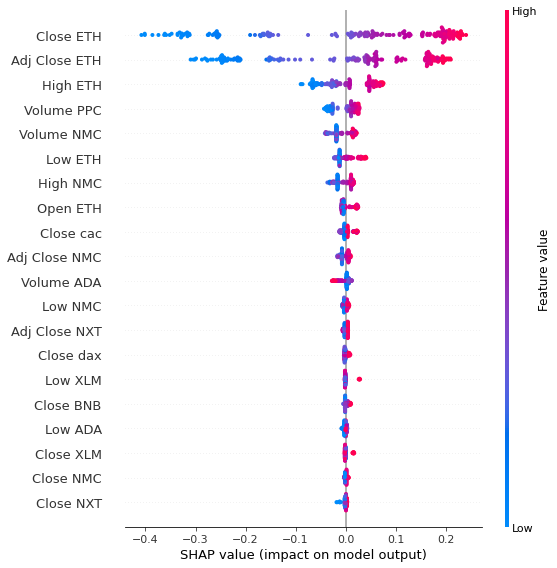

In [ ]:
shap.summary_plot(shaps_eth['first_set'],X_tests_eth['first_set'],feature_names = features_list)

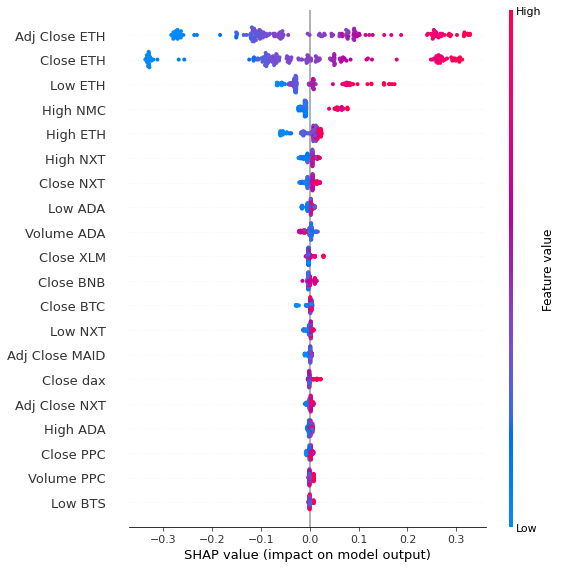

In [ ]:
shap.summary_plot(shaps_eth['second_set'],X_tests_eth['second_set'],feature_names = features_list)

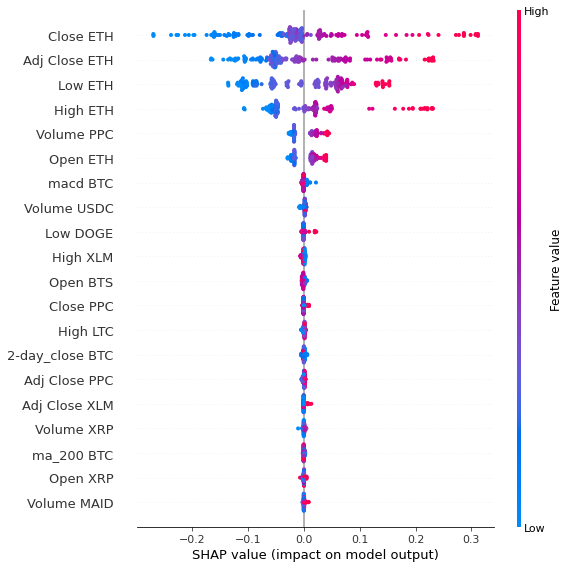

In [ ]:
shap.summary_plot(shaps_eth['third_set'],X_tests_eth['third_set'],feature_names = features_list)

#### BTC

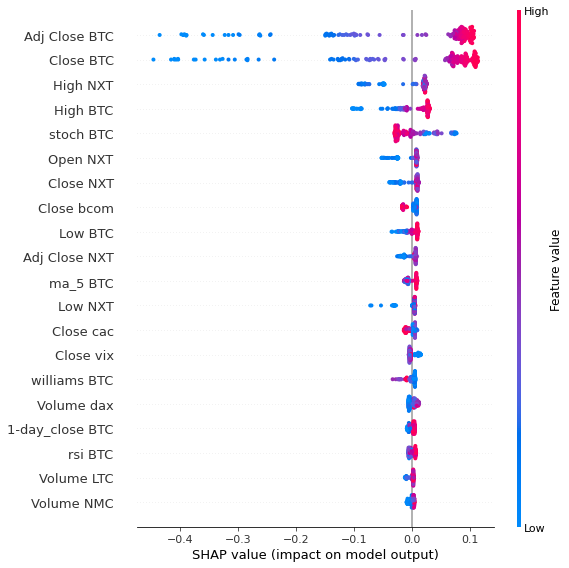

In [ ]:
shap.summary_plot(shaps_btc['first_set'],X_tests_btc['first_set'],feature_names = features_list)

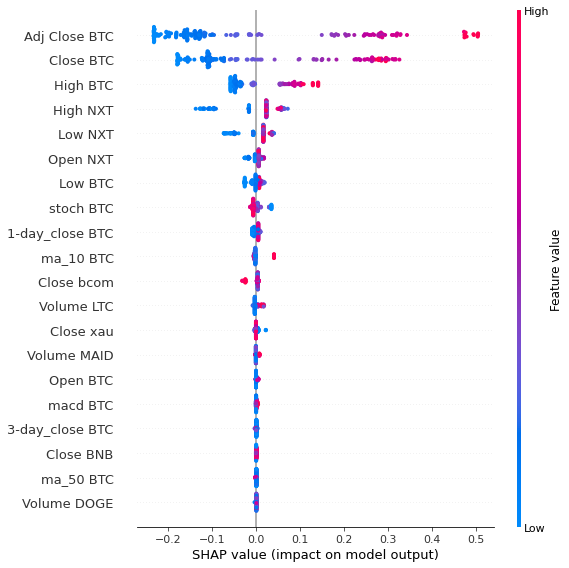

In [ ]:
shap.summary_plot(shaps_btc['second_set'],X_tests_btc['second_set'],feature_names = features_list)

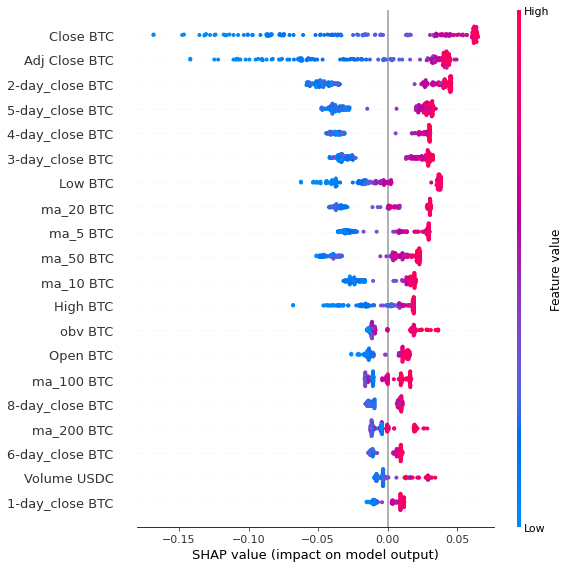

In [ ]:
shap.summary_plot(shaps_btc['third_set'],X_tests_btc['third_set'],feature_names = features_list)